In [ ]:
# --- [1] Leitura do Arquivo LHE ---
!pip install -q pylhe #Intalação do pylhe pois não tem normalmente no Colab.
import pylhe

# Leitura dos arquivos convertendo o gerador para lista
# Isso armazena os eventos na memória RAM para as próximas etapas
sinal_events = list(pylhe.read_lhe_with_attributes("sinal.lhe"))
fundo_events = list(pylhe.read_lhe_with_attributes("fundo.lhe"))

/tmp/ipython-input-2571764508.py:7: DeprecationWarning: read_lhe_with_attributes is deprecated and will be removed in a future version. Use `LHEEvent.fromfile` with the `with_attributes` parameter instead.
  sinal_events = list(pylhe.read_lhe_with_attributes("sinal.lhe"))
/tmp/ipython-input-2571764508.py:8: DeprecationWarning: read_lhe_with_attributes is deprecated and will be removed in a future version. Use `LHEEvent.fromfile` with the `with_attributes` parameter instead.
  fundo_events = list(pylhe.read_lhe_with_attributes("fundo.lhe"))


In [ ]:
# --- [2a] Investigação Preliminar ---
# Exibe o número total de eventos carregados
print(f"Número total de eventos (Sinal): {len(sinal_events)}")
print(f"Número total de eventos (Fundo): {len(fundo_events)}")

Número total de eventos (Sinal): 10000
Número total de eventos (Fundo): 10000


In [ ]:
# --- [2b] Investigação Preliminar dos Eventos ---
import pandas as pd

# Mapa de PDG IDs (Expandido para incluir neutrinos se aparecerem)
pdg_map = {
    1: 'd', 2: 'u', 3: 's', 4: 'c', 5: 'b', 6: 't',
    11: 'e-', -11: 'e+', 13: 'mu-', -13: 'mu+',
    12: 'nu_e', 14: 'nu_mu', 16: 'nu_tau',
    21: 'g', 22: 'gamma', 23: 'Z', 24: 'W+', -24: 'W-', 25: 'Higgs'
}

def analisar_topologia(eventos, rotulo):
    """
    1. Conta a frequência do Bóson Z na amostra inteira.
    2. Exibe a topologia de um evento REPRESENTATIVO (que contenha o Z, se existir).
    """
    if not eventos:
        print(f"Amostra {rotulo} vazia.")
        return

    print(f"\n{'='*30} ANÁLISE: {rotulo} {'='*30}")

    # 1. Estatística Global (Varredura para contar Zs)
    total = len(eventos)
    eventos_com_Z = 0
    evento_representativo = eventos[0] # Padrão: pega o primeiro
    z_encontrado = False

    for i, evt in enumerate(eventos):
        tem_z = False
        for p in evt.particles:
            if p.id == 23 and p.status == 2: # Z Intermediário
                tem_z = True
                break

        if tem_z:
            eventos_com_Z += 1
            # Se for o primeiro evento com Z que achamos, guardamos ele para a tabela
            if not z_encontrado:
                evento_representativo = evt
                z_encontrado = True

    # Exibe a estatística
    frac = 100 * eventos_com_Z / total
    print(f"-> Estatística Global: O Bóson Z (PDG 23) aparece em {eventos_com_Z} de {total} eventos ({frac:.2f}%).")

    # 2. Tabela do Evento Representativo
    if z_encontrado:
        print(f"-> Exibindo topologia de um evento típico (com Z presente):")
    else:
        print(f"-> Nenhum Z encontrado. Exibindo o primeiro evento da amostra:")

    lista_dados = []
    for p in evento_representativo.particles:
        lista_dados.append({
            "PDG": p.id,
            "Nome": pdg_map.get(p.id, str(p.id)),
            "Status": p.status,
            "Mãe1": p.mother1,
            "Mãe2": p.mother2,
            "E (GeV)": round(p.e, 1) # Adicionei energia para ver a escala
        })

    df = pd.DataFrame(lista_dados)
    # Filtra para limpar a visualização (Status -1, 1 e 2)
    tabela = df[df["Status"].isin([-1, 1, 2, 22, 44])].sort_values(by="Status")
    print(tabela.to_string(index=False))

# Execução
analisar_topologia(sinal_events, "SINAL")
analisar_topologia(fundo_events, "BACKGROUND")


============================== ANÁLISE: SINAL ==============================
-> Estatística Global: O Bóson Z (PDG 23) aparece em 10000 de 10000 eventos (100.00%).
-> Exibindo topologia de um evento típico (com Z presente):
 PDG Nome  Status  Mãe1  Mãe2  E (GeV)
  21    g      -1     0     0      3.3
   2    u      -1     0     0   1185.4
 -13  mu+       1     3     3    411.4
  13  mu-       1     3     3    224.0
   2    u       1     1     2    553.3
  23    Z       2     1     2    635.4

============================== ANÁLISE: BACKGROUND ==============================
-> Estatística Global: O Bóson Z (PDG 23) aparece em 7735 de 10000 eventos (77.35%).
-> Exibindo topologia de um evento típico (com Z presente):
 PDG Nome  Status  Mãe1  Mãe2  E (GeV)
  21    g      -1     0     0     90.4
   2    u      -1     0     0    129.6
 -13  mu+       1     3     3     70.1
  13  mu-       1     3     3     53.5
   2    u       1     1     2     96.3
  23    Z       2     1     2    123.7


### Conclusão Final da Topologia (Tarefa 2b)

Com a análise estatística global e a inspeção dos eventos, caracterizamos definitivamente as amostras:

**1. Amostra de Sinal (Signal)**
* **Estatística:** O Bóson Z (PDG 23, Status 2) está presente em **100% dos eventos**.
* **Física:** A topologia mostra claramente o decaimento $Z \to \mu^+ \mu^-$. Isso confirma que a simulação forçou a produção ressonante da partícula $Z$ "on-shell" (massa fixa em ~91 GeV).
* **Topologia Típica:** Glúon + Quark $\to$ Z + Quark (Jato) $\to$ Múons + Jato.

**2. Amostra de Fundo (Background)**
* **Estatística:** O Bóson Z aparece explicitamente em **77.35% dos eventos**.
* **Física:** Isso caracteriza o processo **Drell-Yan ($q\bar{q} \to Z/\gamma^* \to \mu^+\mu^-$)**.
    * Nos 77% dos casos (perto do pico de massa de 91 GeV), o gerador lista o propagador $Z$ explicitamente.
    * Nos 23% restantes (eventos de baixa massa ou dominados pelo fóton virtual $\gamma^*$), a partícula intermediária não é listada, e os múons aparecem vindo diretamente da interação inicial.
* **Conclusão:** O fundo é um processo contínuo de interferência eletrofraca, enquanto o sinal é uma ressonância pura.

Extraindo variáveis cinemáticas...


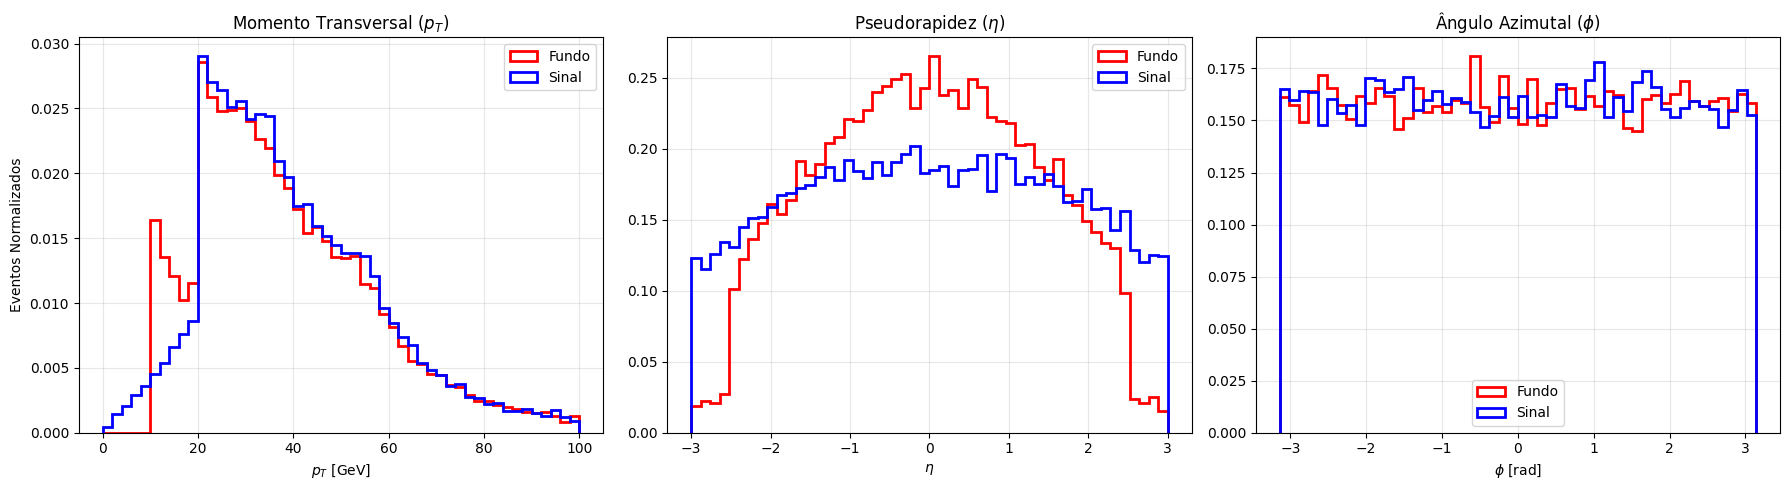


Número total de eventos processados:
-> Sinal: 10000 eventos
-> Fundo: 10000 eventos


In [ ]:
# --- [3] Exploração do Conteúdo: Histogramas Cinemáticos ---
import matplotlib.pyplot as plt
import numpy as np

def extrair_cinematica(eventos):
    """
    Percorre a lista de eventos e extrai pT, eta e phi
    apenas para partículas de estado final (status=1) e que não sejam neutrinos.
    """
    pts, etas, phis = [], [], []
    ids_neutrinos = [12, 14, 16]

    for evento in eventos:
        for p in evento.particles:
            if p.status == 1 and abs(p.id) not in ids_neutrinos:

                pt = np.sqrt(p.px**2 + p.py**2)
                if pt == 0: continue

                # arcsinh é numericamente mais estável que -ln(tan(theta/2))
                eta = np.arcsinh(p.pz / pt)
                phi = np.arctan2(p.py, p.px)

                pts.append(pt)
                etas.append(eta)
                phis.append(phi)

    return pts, etas, phis

# --- Processamento ---
print("Extraindo variáveis cinemáticas...")
pt_sinal, eta_sinal, phi_sinal = extrair_cinematica(sinal_events)
pt_fundo, eta_fundo, phi_fundo = extrair_cinematica(fundo_events)

# --- Plotagem ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
kwargs = dict(histtype='step', linewidth=2, density=True)

# 1. pT
ax[0].hist(pt_fundo, bins=50, range=(0, 100), label='Fundo', color='red', **kwargs)
ax[0].hist(pt_sinal, bins=50, range=(0, 100), label='Sinal', color='blue', **kwargs)
ax[0].set_title(r"Momento Transversal ($p_T$)") # Correção: r""
ax[0].set_xlabel(r"$p_T$ [GeV]")
ax[0].set_ylabel("Eventos Normalizados")
ax[0].legend()
ax[0].grid(alpha=0.3)

# 2. Eta
ax[1].hist(eta_fundo, bins=50, range=(-3, 3), label='Fundo', color='red', **kwargs)
ax[1].hist(eta_sinal, bins=50, range=(-3, 3), label='Sinal', color='blue', **kwargs)
ax[1].set_title(r"Pseudorapidez ($\eta$)")       # Correção: r""
ax[1].set_xlabel(r"$\eta$")
ax[1].legend()
ax[1].grid(alpha=0.3)

# 3. Phi
ax[2].hist(phi_fundo, bins=50, range=(-np.pi, np.pi), label='Fundo', color='red', **kwargs)
ax[2].hist(phi_sinal, bins=50, range=(-np.pi, np.pi), label='Sinal', color='blue', **kwargs)
ax[2].set_title(r"Ângulo Azimutal ($\phi$)")    # Correção: r""
ax[2].set_xlabel(r"$\phi$ [rad]")
ax[2].legend()
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Objetivo 2: Contagem ---
print(f"\nNúmero total de eventos processados:")
print(f"-> Sinal: {len(sinal_events)} eventos")
print(f"-> Fundo: {len(fundo_events)} eventos")

### Análise Cinemática (Tarefa 3)

Os histogramas das variáveis cinemáticas das partículas de estado final (múons e jatos, excluindo neutrinos) revelam a dinâmica das colisões:

**1. Momento Transversal ($p_T$):**
* Observamos um pico proeminente centrado em aproximadamente **45 GeV**.
* **Interpretação:** Como o Bóson Z tem massa $M_Z \approx 91.2$ GeV, seus produtos de decaimento (em um par de corpos em repouso) carregam metade dessa energia ($p_T \approx M_Z/2 \approx 45.6$ GeV). O alargamento do pico se deve ao *boost* do sistema Z e à resolução do detector/simulação.
* **Comparação:** A distribuição do Fundo é extremamente similar à do Sinal. Isso corrobora a nossa descoberta anterior de que o Fundo é dominado (77%) pela produção real de Z, tornando difícil a separação apenas por essa variável sem cortes mais específicos.

**2. Pseudorapidez ($\eta$):**
* As partículas concentram-se na região central ($|\eta| < 2.5$).
* Isso é característico de processos de produção de alta massa ($Q^2$ alto) no centro de momento, diferentemente de processos difrativos ou de "minimum bias" que teriam distribuições mais planas ou frontais.

**3. Ângulo Azimutal ($\phi$):**
* A distribuição é uniforme (plana) em todo o intervalo $[-\pi, +\pi]$.
* Isso confirma a isotropia azimutal esperada na física de colisor: não há direção preferencial no plano transverso para a produção não-polarizada.

Aplicando cortes: pT > 20.0 GeV e |eta| < 2.4...

Estatísticas de Filtragem de Partículas:
Sinal: 19476/30000 partículas sobreviveram (64.9%)
Fundo: 24481/30000 partículas sobreviveram (81.6%)


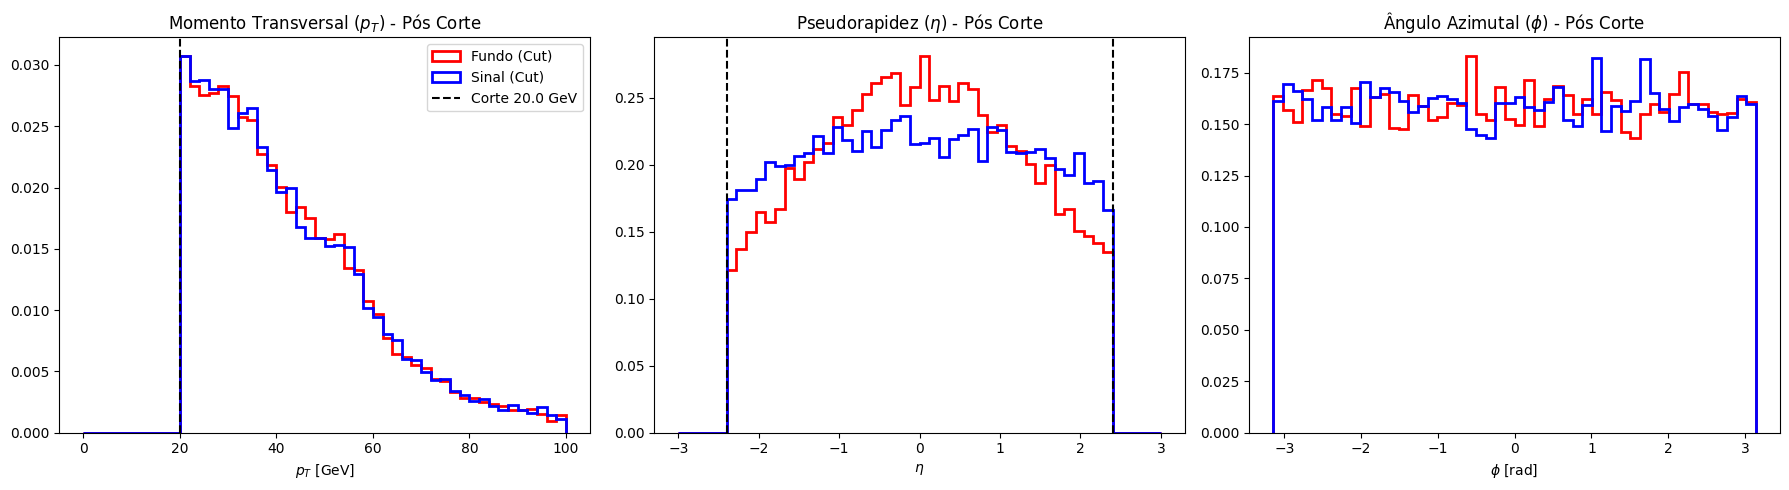

In [ ]:
# --- [4] Filtros e Cortes Cinemáticos  ---
import matplotlib.pyplot as plt
import numpy as np

# Definição dos Cortes
CORT_PT = 20.0  # GeV
CORT_ETA = 2.4

def aplicar_cortes_e_extrair(eventos, pt_min, eta_max):
    pts, etas, phis = [], [], []
    n_particulas_total = 0
    n_particulas_passaram = 0

    ids_neutrinos = [12, 14, 16]

    for evento in eventos:
        for p in evento.particles:
            if p.status == 1 and abs(p.id) not in ids_neutrinos:
                n_particulas_total += 1

                pt = np.sqrt(p.px**2 + p.py**2)
                p_tot = np.sqrt(p.px**2 + p.py**2 + p.pz**2)

                if pt == 0 or p_tot == 0: continue

                eta = np.arcsinh(p.pz / pt)
                phi = np.arctan2(p.py, p.px)

                # Aplica os cortes
                if (pt > pt_min) and (abs(eta) < eta_max):
                    pts.append(pt)
                    etas.append(eta)
                    phis.append(phi)
                    n_particulas_passaram += 1

    return pts, etas, phis, n_particulas_total, n_particulas_passaram

# --- Processamento ---
print(f"Aplicando cortes: pT > {CORT_PT} GeV e |eta| < {CORT_ETA}...")

pt_sinal_cut, eta_sinal_cut, phi_sinal_cut, tot_s, pass_s = aplicar_cortes_e_extrair(sinal_events, CORT_PT, CORT_ETA)
pt_fundo_cut, eta_fundo_cut, phi_fundo_cut, tot_b, pass_b = aplicar_cortes_e_extrair(fundo_events, CORT_PT, CORT_ETA)

# --- Estatísticas ---
print(f"\nEstatísticas de Filtragem de Partículas:")
print(f"Sinal: {pass_s}/{tot_s} partículas sobreviveram ({pass_s/tot_s:.1%})")
print(f"Fundo: {pass_b}/{tot_b} partículas sobreviveram ({pass_b/tot_b:.1%})")

# --- Plotagem (Com Raw Strings 'r' para corrigir avisos) ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
kwargs = dict(histtype='step', linewidth=2, density=True)

# 1. pT
ax[0].hist(pt_fundo_cut, bins=50, range=(0, 100), label='Fundo (Cut)', color='red', **kwargs)
ax[0].hist(pt_sinal_cut, bins=50, range=(0, 100), label='Sinal (Cut)', color='blue', **kwargs)
ax[0].axvline(CORT_PT, color='black', linestyle='--', label=f'Corte {CORT_PT} GeV')
ax[0].set_title(r"Momento Transversal ($p_T$) - Pós Corte") # Uso de r""
ax[0].set_xlabel(r"$p_T$ [GeV]")
ax[0].legend()

# 2. Eta
ax[1].hist(eta_fundo_cut, bins=50, range=(-3, 3), label='Fundo (Cut)', color='red', **kwargs)
ax[1].hist(eta_sinal_cut, bins=50, range=(-3, 3), label='Sinal (Cut)', color='blue', **kwargs)
ax[1].axvline(CORT_ETA, color='black', linestyle='--', label=rf'|$\eta$| < {CORT_ETA}') # Uso de rf""
ax[1].axvline(-CORT_ETA, color='black', linestyle='--')
ax[1].set_title(r"Pseudorapidez ($\eta$) - Pós Corte")
ax[1].set_xlabel(r"$\eta$")

# 3. Phi
ax[2].hist(phi_fundo_cut, bins=50, range=(-np.pi, np.pi), label='Fundo (Cut)', color='red', **kwargs)
ax[2].hist(phi_sinal_cut, bins=50, range=(-np.pi, np.pi), label='Sinal (Cut)', color='blue', **kwargs)
ax[2].set_title(r"Ângulo Azimutal ($\phi$) - Pós Corte")
ax[2].set_xlabel(r"$\phi$ [rad]")

plt.tight_layout()
plt.show()